/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


CNN model has 804,570 parameters
MLP model has 936,330 parameters
Transformer model has 995,082 parameters
RNN model has 807,946 parameters
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 57269896.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1697196.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14277202.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1977221.46it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



CNN - Batch size 1: Time per sample = 0.30659 ms
CNN - Batch size 2: Time per sample = 0.15633 ms
CNN - Batch size 4: Time per sample = 0.07499 ms
CNN - Batch size 8: Time per sample = 0.03936 ms
CNN - Batch size 16: Time per sample = 0.01979 ms
CNN - Batch size 32: Time per sample = 0.01025 ms
CNN - Batch size 64: Time per sample = 0.00515 ms
CNN - Batch size 128: Time per sample = 0.00296 ms
CNN - Batch size 256: Time per sample = 0.00248 ms
CNN - Batch size 512: Time per sample = 0.00217 ms
CNN - Batch size 1024: Time per sample = 0.00199 ms
CNN - Batch size 2048: Time per sample = 0.00170 ms
CNN - Batch size 4096: Time per sample = 0.00166 ms
CNN - Batch size 8192: Time per sample = 0.00159 ms
CNN - Batch size 16384: Time per sample = 0.00159 ms
MLP - Batch size 1: Time per sample = 0.16545 ms
MLP - Batch size 2: Time per sample = 0.08283 ms
MLP - Batch size 4: Time per sample = 0.04092 ms
MLP - Batch size 8: Time per sample = 0.02081 ms
MLP - Batch size 16: Time per sample = 0.010

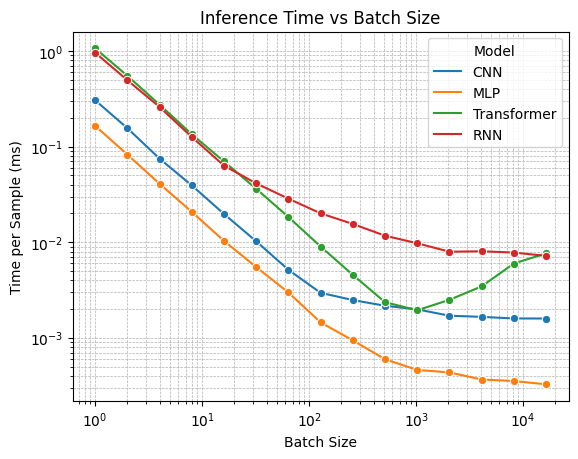

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SimpleTransformer(nn.Module):
    def __init__(self):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(28 * 28, 256)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=256),
            num_layers=2
        )
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.embedding(x).unsqueeze(1) 
        x = self.transformer(x).squeeze(1) 
        x = self.fc(x)
        return x

class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=28, hidden_size=512, num_layers=2, batch_first=True)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = x.squeeze(1) 
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    'CNN': SimpleCNN(),
    'MLP': SimpleMLP(),
    'Transformer': SimpleTransformer(),
    'RNN': SimpleRNN()
}

for name, model in models.items():
    print(f"{name} model has {count_parameters(model):,} parameters")

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

def measure_inference_time(model, loader):
    model.eval()
    total_time = 0
    total_samples = 0
    
    with torch.inference_mode():
        for data, _ in loader:
            data = data.to(device)
            batch_size = data.size(0)

            # Warm-up run
            _ = model(data)
            torch.cuda.synchronize() if torch.cuda.is_available() else None

            # Timed run
            start_time = time.time()
            _ = model(data)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.time()

            total_time += end_time - start_time
            total_samples += batch_size
    
    return (total_time / total_samples) * 1000  # Time per sample in ms

def run_batch_size_experiment(models, batch_sizes):
    results = []

    for model_name, model in models.items():
        model = model.to(device)
        for batch_size in batch_sizes:
            loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            time_per_sample = measure_inference_time(model, loader)
            results.append({
                'Model': model_name,
                'Batch Size': batch_size,
                'Time per Sample (ms)': time_per_sample
            })
            print(f"{model_name} - Batch size {batch_size}: Time per sample = {time_per_sample:.5f} ms")
    
    return pd.DataFrame(results)

def plot_results(df):
    sns.lineplot(data=df, x='Batch Size', y='Time per Sample (ms)', hue='Model', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Inference Time vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Time per Sample (ms)')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

if __name__ == "__main__":
    batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
    results_df = run_batch_size_experiment(models, batch_sizes)
    plot_results(results_df)
